In [51]:
import nest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import elephant
import quantities as pq
import neo
import sys
from scipy.stats import ks_2samp, wilcoxon, mannwhitneyu
plt.rcParams['figure.figsize'] = (14, 10)
import scipy.stats as stats
import itertools
import random

In [2]:
def get_cvs(spike_data):
    """
    Get the CV for each neuron recorded. 
    
    CV = standard_deviation(ISIs)/mean(ISIs)
    """
    cvs = []
     
    spike_data = spike_data.sort_values(by='time_ms')
    grouped = spike_data.groupby(spike_data['sender'])

    for name, group in grouped:
            """
            Each group is senders and times for one value of senders. That is, we iterate through all 
            neurons. And the times for each neuron is in sorted order. Therefore, the cvs
            returned must have the same order. So cvs contain cv of neuron 1, then neuron 2 .... then neuron N.
            """
            t = np.asarray(group['time_ms'])
            spiketrain = neo.core.SpikeTrain(t * pq.ms, t_start=0*pq.ms, t_stop=10000*pq.ms)
            isi = elephant.statistics.isi(spiketrain)
            cv = elephant.statistics.cv(isi)
            cvs.append(cv)
            
    return cvs

In [3]:
def get_cv_lists(exc, inh):
    cv_list_exc = list()
    for i in range(1,11):
        exc_cvs = get_cvs(exc[i])
        cv_list_exc.append(exc_cvs)

    cv_list_inh = list()
    for i in range(1,11):
        inh_cvs = get_cvs(inh[i])
        cv_list_inh.append(inh_cvs)
    return cv_list_exc, cv_list_inh

Lets try to run KS-test on randomly drawn samples from each model, e.g. 500 samples. Then see if tests pass.

In [4]:
def round_1_2():
    """
    Get spike data from brunel model with rounded spike times and delays drawn from discrete interval [1.0, 2.0].
    """
    spike_path = '/opt/data/spike_data/brunel_10s/brunel_rounding_1_2'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_1.0_2.0_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_1.0_2.0_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    return exc, inh

In [5]:
def exact_1_2():
    """
    Get spike data from brunel model with exact spike times and delays drawn form discrete interval [1.0, 2.0].
    """
    spike_path = '/opt/data/spike_data/brunel_10s/brunel_exact_1_2'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_1.0_2.0_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_1.0_2.0_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    return exc, inh

In [6]:
def round_equal():
    """
    Get spike data from brunel model with rounded spikes times and delay form interval [0.9375, 2.0625].
    """
    spike_path = '/opt/data/spike_data/brunel_10s/brunel_rounding_0_9375_2_0625'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_0.9375_2.0625_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_True_delay_0.9375_2.0625_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
        
    return exc, inh

In [7]:
def exact_equal():
    """
    Get spike data from brunel with exact spike times and delays drawn from interval [0.9375, 2.0625].
    """
    
    spike_path = '/opt/data/spike_data/brunel_10s/brunel_exact_0_9375_2_0625'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_0.9375_2.0625_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_rounding_False_delay_0.9375_2.0625_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    
    return exc, inh

In [8]:
def continuous():
    """
    Get spike data from brunel model with delay drawn from continuous interval [1.0, 2.0].
    """
    spike_path = '/opt/data/spike_data/brunel_10s/brunel_continuous'
    exc = {}
    for i in range(1,11):
        exc[i] = pd.read_csv(r'{}/brunel_continuous_delay_1.0_2.0_seed_{}_spikes_exc-12502-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')

    inh = {}
    for i in range(1,11):
        inh[i] = pd.read_csv(r'{}/brunel_continuous_delay_1.0_2.0_seed_{}_spikes_inh-12503-0.dat'.format(spike_path, i),
                             skiprows=2,sep='\t')
    return exc, inh

In [9]:
def ks_test(value_list, N=500):
    """
    Perform KS-test on all possible pairs of simulations from same model. (10 simulations). 
    Return statistic and p-values. Use N randomly drawn samples from each simulation being compared.
    """
    statistics = []
    p_values = []
    for i in range(0,10):
        for j in range(0,i):
            x1 = random.sample(value_list[i], N)
            x2 = random.sample(value_list[j], N)
            statistic = ks_2samp(x1, x2, alternative='two-sided')[0]
            p_value = ks_2samp(x1, x2, alternative='two-sided')[1]
            p_values.append(p_value)
            statistics.append(statistic)
    return statistics, p_values
        

In [10]:
def num_fail_pass(statistics, p_values):
    """
    Get number of tests which failed and which passed.
    """
    failed = 0
    passed = 0
    for i in range(0,len(statistics)):
        if statistics[i] > p_values[i]:
            # test fails
            failed += 1
        else:
            passed += 1
    s = str(passed) + ' tests passed, ' + str(failed) + ' tests failed.'
    return s

In [11]:
exc, inh = round_1_2()
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)
statistics, p_values = ks_test(cv_list_exc)
s = num_fail_pass(statistics, p_values)
print(s)

43 tests passed, 2 tests failed.


In [12]:
statistics, p_values = ks_test(cv_list_inh)
s = num_fail_pass(statistics, p_values)
print(s)

41 tests passed, 4 tests failed.


Next model:

In [13]:
exc, inh = exact_1_2()
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)
statistics, p_values = ks_test(cv_list_exc)
s = num_fail_pass(statistics, p_values)
print(s)

41 tests passed, 4 tests failed.


In [14]:
statistics, p_values = ks_test(cv_list_inh)
s = num_fail_pass(statistics, p_values)
print(s)

40 tests passed, 5 tests failed.


Next model:

In [15]:
exc, inh = round_equal()
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)
statistics, p_values = ks_test(cv_list_exc)
s = num_fail_pass(statistics, p_values)
print(s)

40 tests passed, 5 tests failed.


In [16]:
statistics, p_values = ks_test(cv_list_inh)
s = num_fail_pass(statistics, p_values)
print(s)

40 tests passed, 5 tests failed.


Next model:

In [17]:
exc, inh = exact_equal()
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)
statistics, p_values = ks_test(cv_list_exc)
s = num_fail_pass(statistics, p_values)
print(s)

41 tests passed, 4 tests failed.


In [18]:
statistics, p_values = ks_test(cv_list_inh)
s = num_fail_pass(statistics, p_values)
print(s)

40 tests passed, 5 tests failed.


Last model:

In [19]:
exc, inh = continuous()
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)
statistics, p_values = ks_test(cv_list_exc)
s = num_fail_pass(statistics, p_values)
print(s)

36 tests passed, 9 tests failed.


In [20]:
statistics, p_values = ks_test(cv_list_inh)
s = num_fail_pass(statistics, p_values)
print(s)

41 tests passed, 4 tests failed.


## Mock data

### KS-test
We check if KS test is working for large datasets. Create some mock data of large size, from same distribution so we know that it should pass. See how it works. Lets use Gaussian distribution, distribution of size 10000.

In [22]:
def ks_test(value_list):
    """
    Perform KS-test on all possible pairs of simulations from same model. (10 simulations). 
    Return statistic and p-values.
    """
    statistics = []
    p_values = []
    for i in range(0,10):
        for j in range(0,i):
            statistic = ks_2samp(value_list[i], value_list[j], alternative='two-sided')[0]
            p_value = ks_2samp(value_list[i], value_list[j], alternative='two-sided')[1]
            p_values.append(p_value)
            statistics.append(statistic)
    return statistics, p_values
        

In [23]:
x1 = np.random.normal(0, 1, 10000)
x2 = np.random.normal(0, 1, 10000)
x3 = np.random.normal(0, 1, 10000)
x4 = np.random.normal(0, 1, 10000)
x5 = np.random.normal(0, 1, 10000)
x6 = np.random.normal(0, 1, 10000)
x7 = np.random.normal(0, 1, 10000)
x8 = np.random.normal(0, 1, 10000)
x9 = np.random.normal(0, 1, 10000)
x10 = np.random.normal(0, 1, 10000)
x = [x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]
s,p = ks_test(x)
print(num_fail_pass(s,p))

42 tests passed, 3 tests failed.


Even when testing 10 different distributions of the same size frawn from the same distribution, the tests does not all pass.

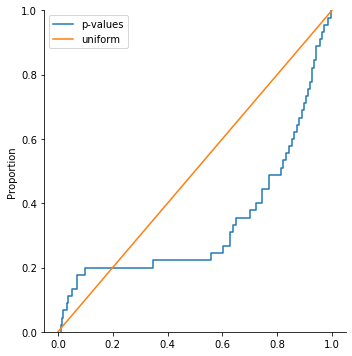

In [25]:
sns.displot(p,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

See also that p-values are not uniformly distributed. 

### Wilcoxon Test

Obviously KS test is not well fit for large datasets. Lets try and check Wilcoxon test. Recommended by scipy instead of Mann Whiitney U test as it expects independent samples.

Wilcoxon test has null hypothesis that H_0= The observations X_i-Y_i are symmetric about mean=0.  Reject null hypothesis if statistic > p_value.

In [47]:
def wcx_test(value_list):
    """
    Perform Wilcoxon-test on all possible pairs of simulations from same model. (10 simulations). 
    Return statistic and p-values.
    """
    statistics = []
    p_values = []
    for i in range(0,10):
        for j in range(0,i):
            statistic = wilcoxon(value_list[i], value_list[j], alternative='two-sided')[0]
            p_value = wilcoxon(value_list[i], value_list[j], alternative='two-sided')[1]
            p_values.append(p_value)
            statistics.append(statistic)
    return statistics, p_values
        

In [48]:
x1 = np.random.normal(0, 1, 10000)
x2 = np.random.normal(0, 1, 10000)
x3 = np.random.normal(0, 1, 10000)
x4 = np.random.normal(0, 1, 10000)
x5 = np.random.normal(0, 1, 10000)
x6 = np.random.normal(0, 1, 10000)
x7 = np.random.normal(0, 1, 10000)
x8 = np.random.normal(0, 1, 10000)
x9 = np.random.normal(0, 1, 10000)
x10 = np.random.normal(0, 1, 10000)
x = [x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]
s,p = wcx_test(x)
print(num_fail_pass(s,p))

0 tests passed, 45 tests failed.


The wilcoxon test is not well suited for large datasets. Even worse than the KS-test. Lets double check that whtiney U is bad as well.

In [50]:
def mwu_test(value_list):
    """
    Perform Wilcoxon-test on all possible pairs of simulations from same model. (10 simulations). 
    Return statistic and p-values.
    """
    statistics = []
    p_values = []
    for i in range(0,10):
        for j in range(0,i):
            statistic = mannwhitneyu(value_list[i], value_list[j], alternative='two-sided')[0]
            p_value = mannwhitneyu(value_list[i], value_list[j], alternative='two-sided')[1]
            p_values.append(p_value)
            statistics.append(statistic)
    return statistics, p_values
        

In [52]:
s,p = mwu_test(x)
print(num_fail_pass(s,p))

0 tests passed, 45 tests failed.


Also not well suited.

In [53]:
def ks_test(value_list):
    """
    Perform KS-test on all possible pairs of simulations from same model. (10 simulations). 
    Return statistic and p-values.
    """
    statistics = []
    p_values = []
    for i in range(0,10):
        for j in range(0,i):
            statistic = ks_2samp(value_list[i], value_list[j], alternative='two-sided')[0]
            p_value = ks_2samp(value_list[i], value_list[j], alternative='two-sided')[1]
            p_values.append(p_value)
            statistics.append(statistic)
    return statistics, p_values
        

In [58]:
x1 = np.random.normal(0, 1, 10000)
x2 = np.random.normal(0, 1, 10000)
x3 = np.random.normal(0, 1, 10000)
x4 = np.random.normal(0, 1, 10000)
x5 = np.random.normal(0, 1, 10000)
x6 = np.random.normal(0, 1, 10000)
x7 = np.random.normal(0, 1, 10000)
x8 = np.random.normal(0, 1, 10000)
x9 = np.random.normal(0, 1, 10000)
x10 = np.random.normal(0, 1, 10000)
x = [x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]
s,p = ks_test(x)
print(num_fail_pass(s,p))

43 tests passed, 2 tests failed.


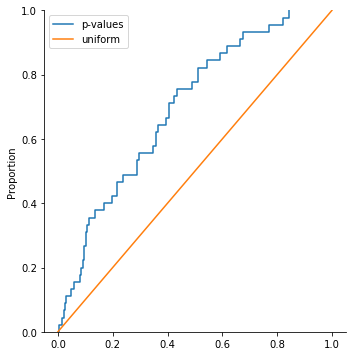

In [59]:
sns.displot(p,kind='ecdf',label='p-values')
plt.plot([0,1],[0,1],label='uniform')
plt.legend()
plt.show()

Sometimes all tests pass, sometimes they do not. Try to find a cut off value for the statistic?

SOme mean that you reject hypothesis if p-value is less than your significance level. So we actually check the wrong thing when deciding whether it passes or not. Lets fix this.

In [64]:
def num_fail_pass(p_values, significance_level=0.05):
    """
    Get number of tests which failed and which passed.
    """
    failed = 0
    passed = 0
    for i in range(0,len(p_values)):
        if  p_values[i] < significance_level:
            # reject hypothesis of equal distributions
            failed += 1
        else:
            passed += 1
    s = str(passed) + ' tests passed, ' + str(failed) + ' tests failed.'
    return s

In [70]:
x1 = np.random.normal(0, 1, 10000)
x2 = np.random.normal(0, 1, 10000)
x3 = np.random.normal(0, 1, 10000)
x4 = np.random.normal(0, 1, 10000)
x5 = np.random.normal(0, 1, 10000)
x6 = np.random.normal(0, 1, 10000)
x7 = np.random.normal(0, 1, 10000)
x8 = np.random.normal(0, 1, 10000)
x9 = np.random.normal(0, 1, 10000)
x10 = np.random.normal(0, 1, 10000)
x = [x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]
s,p = ks_test(x)
print(num_fail_pass(p))

43 tests passed, 2 tests failed.


Still sometimes fail. Try higher singificance level, e.g. 10%.

In [99]:
x1 = np.random.normal(0, 1, 10000)
x2 = np.random.normal(0, 1, 10000)
x3 = np.random.normal(0, 1, 10000)
x4 = np.random.normal(0, 1, 10000)
x5 = np.random.normal(0, 1, 10000)
x6 = np.random.normal(0, 1, 10000)
x7 = np.random.normal(0, 1, 10000)
x8 = np.random.normal(0, 1, 10000)
x9 = np.random.normal(0, 1, 10000)
x10 = np.random.normal(0, 1, 10000)
x = [x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]
s,p = ks_test(x)
print(num_fail_pass(p,0.005))

43 tests passed, 2 tests failed.


Still not all passing each time.


Try to run KS test on smaller parts of the dsitribution.

In [104]:
for n in range(50,10000,50):
    y1 = x1[n-50:n]
    y2 = x2[n-50:n]
    p_value = ks_2samp(y1, y2, alternative='two-sided')[1]
    bol = p_value > 0.01
    if (bol==False):
        print('fail')

In [105]:
for n in range(50,10000,50):
    y1 = x2[n-50:n]
    y2 = x3[n-50:n]
    p_value = ks_2samp(y1, y2, alternative='two-sided')[1]
    bol = p_value > 0.01
    if (bol==False):
        print('fail')

In [106]:
for n in range(50,10000,50):
    y1 = x3[n-50:n]
    y2 = x4[n-50:n]
    p_value = ks_2samp(y1, y2, alternative='two-sided')[1]
    bol = p_value > 0.01
    if (bol==False):
        print('fail')

fail


# Kullback-Leibler divergence

"The Kullback-Leibler divergence is based on the entropy and a measure to quantify how different two probability distributions are, or in other words, how much information is lost if we approximate one distribution with another distribution.” [see article](https://johfischer.com/2021/12/31/intuitive-explanation-of-the-kullback-leibler-divergence/)

Retrieving KL div for mock data, should be close to zero.

In [143]:
x1 = np.random.normal(0, 1, 10000)
x2 = np.random.normal(0, 1, 10000)
x3 = np.random.normal(0, 1, 10000)
x4 = np.random.normal(0, 1, 10000)
x5 = np.random.normal(0, 1, 10000)
x6 = np.random.normal(0, 1, 10000)
x7 = np.random.normal(0, 1, 10000)
x8 = np.random.normal(0, 1, 10000)
x9 = np.random.normal(0, 1, 10000)
x10 = np.random.normal(0, 1, 10000)
x = [x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]

In [144]:
def compute_probs(data, n=10): 
    h, e = np.histogram(data, n)
    p = h/data.shape[0]
    return e, p

def support_intersection(p, q): 
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

def get_probs(list_of_tuples): 
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

def kl_divergence(p, q): 
    return np.sum(p*np.log(p/q))

def js_divergence(p, q):
    m = (1./2.)*(p + q)
    return (1./2.)*kl_divergence(p, m) + (1./2.)*kl_divergence(q, m)

def compute_kl_divergence(train_sample, test_sample, n_bins=10): 
    """
    Computes the KL Divergence using the support 
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)

    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    return kl_divergence(p, q)

In [145]:
divs = []
for i in range(0,10):
        for j in range(0,i):
            kl = compute_kl_divergence(x[i],x[j])
            divs.append(kl)

In [146]:
divs

[0.0018627002297798157,
 0.0010033554180329054,
 0.001758335521306645,
 0.0013524487657290778,
 0.0008197562485540522,
 0.0009711488447318604,
 0.0011689276851307405,
 0.0004476966168484448,
 0.000762352163523453,
 0.0007422523676422412,
 0.0006105664328015524,
 0.0011519025572054586,
 0.0023760382271283157,
 0.0017163437645266242,
 0.0015730001943425726,
 0.0014697022739483321,
 0.0009210113045681444,
 0.0006806056364601264,
 0.000733774468675833,
 0.0006506485367411505,
 0.0006758631208542685,
 0.0010805947955126677,
 0.0010394928217138618,
 0.0006246175722793395,
 0.0006550312751939436,
 0.0006722999829150478,
 0.001257117934303,
 0.00036599887352601007,
 0.0016445376468322565,
 0.00028578408471566404,
 0.0014772421707451148,
 0.0006496755603503274,
 0.0005865964526417958,
 0.000876361729968573,
 0.0007030987982152101,
 0.0008955223243248057,
 0.0012618585320233666,
 0.0018009510618188357,
 0.001038982640304918,
 0.0014395963760344087,
 0.0012707939453243714,
 0.0017951048382547927,

In [150]:
print('maximum difference: ',max(divs), ' Minimum difference: ', min(divs))

maximum difference:  0.0023760382271283157  Minimum difference:  0.00028578408471566404


Now try on simulations from same model, the brunel model with rounded spike times and delays drawn from discrete interval [1.0, 2.0]. 

In [151]:
exc, inh = round_1_2()
cv_list_exc, cv_list_inh = get_cv_lists(exc, inh)

In [152]:
def compute_probs(data, n=10): 
    h, e = np.histogram(data, n)
    p = h/len(data)
    return e, p

def support_intersection(p, q): 
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

def get_probs(list_of_tuples): 
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

def kl_divergence(p, q): 
    return np.sum(p*np.log(p/q))

def js_divergence(p, q):
    m = (1./2.)*(p + q)
    return (1./2.)*kl_divergence(p, m) + (1./2.)*kl_divergence(q, m)

def compute_kl_divergence(train_sample, test_sample, n_bins=10): 
    """
    Computes the KL Divergence using the support 
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)

    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    return kl_divergence(p, q)

In [153]:
def kl_div(value_list):
    """
    Perform KS-test on all possible pairs of simulations from same model. (10 simulations). 
    Return statistic and p-values.
    """
    divs = []
    
    for i in range(0,10):
        for j in range(0,i):
            kl = compute_kl_divergence(value_list[i], value_list[j])
            divs.append(kl)
    return divs
        

In [230]:
def kl_div_cont(value_list):
    """
    Perform KS-test on all possible pairs of simulations from same model. (10 simulations). 
    Return statistic and p-values.
    """
    divs = []
    
    for i in range(0,10):
        for j in range(0,i):
            kl = cumulative_kl(value_list[i], value_list[j])
            divs.append(kl)
    return divs
        

In [232]:
d1c = kl_div_cont(cv_list_exc)
d1c

<ipython-input-227-bdf727934552>:29: RuntimeWarning:divide by zero encountered in true_divide
<ipython-input-227-bdf727934552>:29: RuntimeWarning:invalid value encountered in true_divide
<ipython-input-227-bdf727934552>:29: RuntimeWarning:divide by zero encountered in log


[-0.0024060591128203246,
 nan,
 nan,
 -0.011336557837948735,
 0.010666269308719833,
 nan,
 0.008823483751874583,
 0.007030990906508494,
 nan,
 0.012431153057487654,
 -0.017566022753544797,
 -0.001023604432937586,
 nan,
 -0.021180352705993388,
 -0.0005043668889646025,
 -0.003926589492667998,
 -0.008617067490174768,
 nan,
 0.013730033573096767,
 0.01718634059858326,
 -0.020543837981522484,
 -0.011287815008082513,
 -0.006057272007739534,
 nan,
 -0.0007285420904182827,
 0.018555511329412022,
 -0.009005751365393722,
 -0.01181800608483441,
 0.011694255886116611,
 -0.006170074549632698,
 nan,
 0.0016959429137362036,
 0.009000929181739892,
 -0.022199155486032907,
 -0.004463672177880795,
 -0.0027536384277525583,
 -0.0006830656569994931,
 -0.0005609491215822215,
 nan,
 0.008553985821022847,
 0.0061294622751013605,
 -0.005958835940208074,
 -0.008713151747107739,
 0.011179749959549179,
 -0.00945959730132262]

In [154]:
d1 = kl_div(cv_list_exc)

In [155]:
d1

[0.0008117387682380643,
 0.0007743302703848301,
 0.0011323883882996526,
 0.0007718222587935656,
 0.0016002265717752933,
 0.002317316664821285,
 0.0005626518685845134,
 0.001012372834062225,
 0.0012487496963858881,
 0.0008844892844726012,
 0.0009287870511238429,
 0.0015108916143229522,
 0.0023532089695504927,
 0.0022211253738781893,
 0.001855789812874045,
 0.001721275458554683,
 0.0022130213901066574,
 0.0017316941490306994,
 0.003429361850875966,
 0.0020551939648568284,
 0.001210957112674034,
 0.0016603574312934316,
 0.0019570801229812423,
 0.0014952407072140548,
 0.00233451882984233,
 0.001589741727290506,
 0.001270450744341581,
 0.0014277469969620495,
 0.0017836383080754286,
 0.0014238364853801054,
 0.0013603644111557477,
 0.0020933961281632057,
 0.0016678076338754579,
 0.0017554119801222639,
 0.0006423682894323704,
 0.0014597908898157416,
 0.0013173904169367775,
 0.0015158721106896353,
 0.0021037977542333348,
 0.0005392714495221113,
 0.0010079333668968236,
 0.0028323890844495943,
 0

In [156]:
print('maximum difference: ',max(d1), ' Minimum difference: ', min(d1))

maximum difference:  0.0037054357186489064  Minimum difference:  0.0005392714495221113


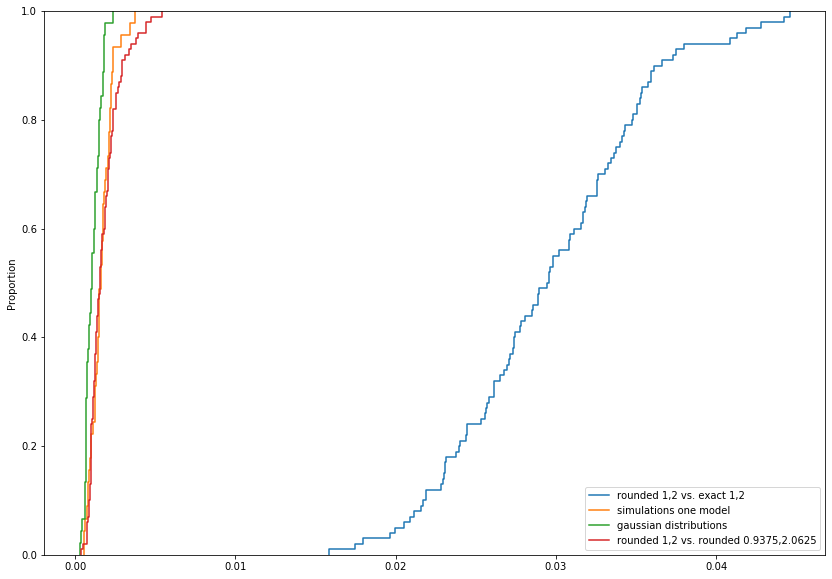

In [177]:
_, axs = plt.subplots(1)
sns.ecdfplot(d2,ax=axs, label='rounded 1,2 vs. exact 1,2')
sns.ecdfplot(d1,ax=axs, label='simulations one model')
sns.ecdfplot(divs,ax=axs, label='gaussian distributions')
sns.ecdfplot(d3,ax=axs, label='rounded 1,2 vs. rounded 0.9375,2.0625')
plt.legend();

Try models against eachother. Brunel with rounded spike times on [1.0,2.0] vs. exact spike times on [1.0,2.0].

In [157]:
def kl_div(value_list_1, value_list_2):
    """
    Perform Kl-div on all possible compinations of pairwise simulations in two different models.
    """
    comb = list(itertools.product(value_list_1, value_list_2))

    divs = []
    for i in range(0,len(comb)):
        kl = compute_kl_divergence(comb[i][0],comb[i][1])
        divs.append(kl)
    return divs

In [158]:
exc_2, inh_2 = exact_1_2()

In [159]:
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [160]:
# epect these to be very different
d2 = kl_div(cv_list_exc, cv_list_exc_2)
d2

[0.03166352170886119,
 0.02395313170306795,
 0.03262528373633848,
 0.03085254294492102,
 0.02942727589000347,
 0.03341787294756279,
 0.025614455023606413,
 0.027333827354051845,
 0.023094587805884803,
 0.03324091773919981,
 0.028573348569437128,
 0.02171072851407407,
 0.02890534471082378,
 0.02963712257833157,
 0.026128901806124618,
 0.031154182815069147,
 0.023032595744856287,
 0.024029094045857038,
 0.020888677779828394,
 0.029815471365979705,
 0.034817081018165,
 0.02652561404210974,
 0.032587048317121475,
 0.03168175011481056,
 0.03196465692859398,
 0.03424325212259732,
 0.0278100558386761,
 0.0274149650219152,
 0.02533383113860744,
 0.034141170076305474,
 0.025668959459904984,
 0.020498115567645133,
 0.02696574449981913,
 0.02441451949096171,
 0.02441851198814876,
 0.028515523516782316,
 0.02114037965174837,
 0.022933025420887817,
 0.01794383721490707,
 0.028066630720717804,
 0.03186479376211792,
 0.02378130025753992,
 0.030817281561498676,
 0.02954026785750137,
 0.029543619481967

In [161]:
print('maximum difference: ',max(d2), ' Minimum difference: ', min(d2))

maximum difference:  0.04459365108238149  Minimum difference:  0.015837590165627375


Brunel with rounded spiek tiems and delays on [1.0,2.0] vs. rounded spike times and delays on [0.9375,2.0625].

In [162]:
exc_2, inh_2 = round_equal()
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [163]:
# expect these to be more equal than last case, but not as equal as simulations from same model.
d3 = kl_div(cv_list_exc, cv_list_exc_2)
d3

[0.001288661323909908,
 0.0020567852057046055,
 0.0010155038186731012,
 0.0011514285367570142,
 0.0014350040606396993,
 0.00047574405247362663,
 0.0011355901789951162,
 0.0009855227728535042,
 0.0015387183842418724,
 0.002334853384760971,
 0.0007237328281119761,
 0.002569825067805315,
 0.0008522180929431994,
 0.0014819193631671285,
 0.0014544961529765732,
 0.00039069366512981343,
 0.001246452130276093,
 0.0009449864649560733,
 0.0022690489769461586,
 0.0020316740108111174,
 0.0016746454242847174,
 0.00314155087101951,
 0.0020647337916813893,
 0.0009408238258907211,
 0.0021493799135484893,
 0.002107177514177717,
 0.0018531725998193007,
 0.0009849588441856712,
 0.0019207969974309887,
 0.002910273927395429,
 0.002120614242186866,
 0.003819574750492672,
 0.0018746367329721659,
 0.001286237817761846,
 0.0010011432676431849,
 0.0008079359910085357,
 0.0022323591571856982,
 0.002363568759706671,
 0.002843677908426768,
 0.001798798175932377,
 0.0010270239517829558,
 0.0025325514318817292,
 0.0

In [164]:
print('maximum difference: ',max(d3), ' Minimum difference: ', min(d3))

maximum difference:  0.005422198576236496  Minimum difference:  0.00039069366512981343


rounded spikes [1.0,2.0] vs. continuous case.

In [165]:
exc_2, inh_2 = continuous()
cv_list_exc_2, cv_list_inh_2 = get_cv_lists(exc_2, inh_2)

In [166]:
d4 = kl_div(cv_list_exc, cv_list_exc_2)
d4

[0.028386746467873265,
 0.02620871249454446,
 0.03306757270730868,
 0.03693723694548769,
 0.02991955151277597,
 0.02358695188605447,
 0.018948000053628747,
 0.02571815820847716,
 0.034587959217445965,
 0.033087992635577726,
 0.026512147032380542,
 0.02351810947694625,
 0.031866083874991416,
 0.03523645844107664,
 0.025786880152606644,
 0.021078783190032466,
 0.01582604810241075,
 0.022891296609046815,
 0.03283627216015289,
 0.029515287978229627,
 0.030689922384139076,
 0.029405677993277073,
 0.03506777702576572,
 0.03763394436275531,
 0.031545857195590034,
 0.02595997709344659,
 0.019910666383790177,
 0.027019848854376045,
 0.033972139337905875,
 0.03344945613080309,
 0.02276523692990469,
 0.021140433746462052,
 0.027886105656655065,
 0.030924352393280716,
 0.022921985899269588,
 0.01867026296876746,
 0.014447329032292127,
 0.020461434349768954,
 0.030158376099041602,
 0.027098066280999537,
 0.0293713601991243,
 0.025254330133495446,
 0.03426094225890559,
 0.03744853972412512,
 0.02972

In [167]:
print('maximum difference: ',max(d4), ' Minimum difference: ', min(d4))

maximum difference:  0.04905116584387103  Minimum difference:  0.012157828239834783


The question is how many bins should we use?  And is it correct to use the discrete distribution version? 

In [227]:
def ecdf(x,tot_min,tot_max):
    x = np.sort(list(x)+[tot_min,tot_max])
    u, c = np.unique(x, return_counts=True)
    n = len(x)
    y = (np.cumsum(c) - 0.5)/n
    def interpolate_(x_):
        yinterp = np.interp(x_, u, y, left=tot_min, right=tot_max)
        return yinterp
    return interpolate_

def cumulative_kl(x,y,fraction=0.5): 
    dx = np.diff(np.sort(np.unique(x)))
    dy = np.diff(np.sort(np.unique(y)))
    ex = np.min(dx)
    ey = np.min(dy)
    e = np.min([ex,ey])*fraction
    n = len(x)
    # total max
    max_x = max(x)
    max_y = max(y)
    tot_max = max(max_x,max_y)
    # total min
    min_x = min(x)
    min_y = min(y)
    tot_min = min(min_x, min_y)
    # send tot_max and tot_min to interpolation limits
    P = ecdf(x,tot_min,tot_max)
    Q = ecdf(y,tot_min,tot_max)  
    KL = (1./n)*np.sum(np.log((P(x) - P(x-e))/(Q(x) - Q(x-e)))) - 1
    return KL

In [188]:
np.min(np.diff(np.sort(np.unique(x1))))

9.997572240905139e-08

In [190]:
e = 0.5*np.min(np.diff(np.sort(np.unique(x2))))

In [215]:
min(ecdf_x1(x1)-ecdf_x1(x1-e))

4.781463311225032e-13

In [216]:
np.argmin(ecdf_x2(x1)-ecdf_x2(x1-e))

1587

In [217]:
ecdf_x2(x1[1585:1590])

array([0.68156668, 0.72246814, 0.        , 0.00262565, 0.39908235])

In [218]:
ecdf_x2(x1[1585:1590]-e)

array([0.68156668, 0.72246814, 0.        , 0.00262565, 0.39908235])

In [210]:
ecdf_x2(x1[1585:1590])-ecdf_x2(x1[1585:1590]-e)

array([1.32175004e-09, 1.81493853e-09, 0.00000000e+00, 3.36784819e-11,
       1.98755845e-10])

In [211]:
x1[1585:1590]

array([ 0.47677817,  0.59802523, -3.9906047 , -2.94027109, -0.24173772])

In [212]:
min(x1)

-4.087882594514999

In [213]:
min(x2)

-3.5331042009352496

In [205]:
np.mean(a)

inf

<ipython-input-203-7fe1acf1458a>:1: RuntimeWarning:divide by zero encountered in true_divide


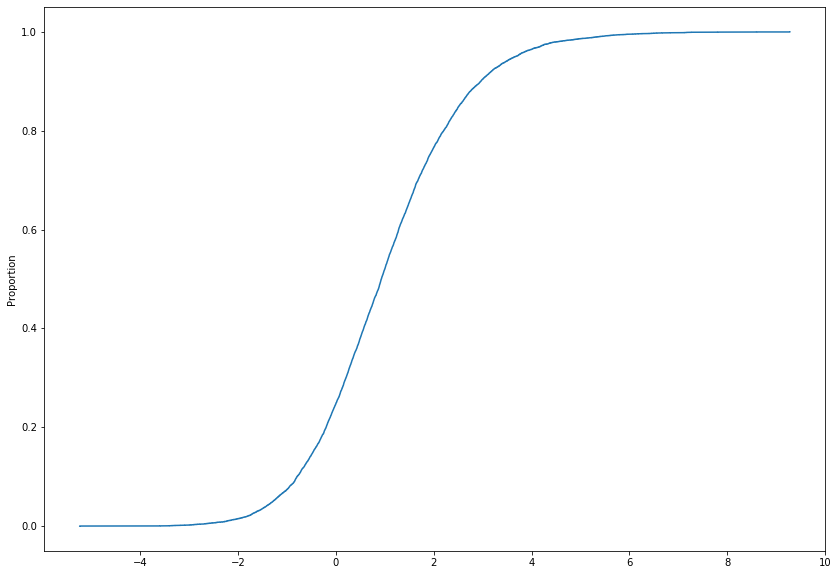

In [203]:
a = (ecdf_x1(x1)-ecdf_x1(x1-e))/(ecdf_x2(x1)-ecdf_x2(x1-e))
sns.ecdfplot(np.log(a))

In [ ]:
x1 = np.random.normal(0, 1, 10000)
x2 = np.random.normal(0, 1, 10000)
x3 = np.random.normal(0, 1, 10000)
x4 = np.random.normal(0, 1, 10000)
x5 = np.random.normal(0, 1, 10000)
x6 = np.random.normal(0, 1, 10000)
x7 = np.random.normal(0, 1, 10000)
x8 = np.random.normal(0, 1, 10000)
x9 = np.random.normal(0, 1, 10000)
x10 = np.random.normal(0, 1, 10000)
x = [x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]

In [228]:
divs_cont = []
for i in range(0,10):
        for j in range(0,i):
            kl = cumulative_kl(x[i],x[j],fraction=0.05)
            divs_cont.append(kl)

In [229]:
np.array(divs_cont)

array([ 0.02276723,  0.01555777,  0.01299636, -0.01284911, -0.00031115,
       -0.00417728,  0.01262605,  0.02605892,  0.02595068,  0.00036448,
       -0.02068981, -0.01931756, -0.00619723, -0.0279479 , -0.0220647 ,
        0.00990452,  0.00178968,  0.00036518, -0.01010138,  0.00356242,
       -0.03541187,  0.006663  ,  0.01657231,  0.01702439,  0.01012413,
        0.02294688, -0.0021284 , -0.00250318, -0.01080888,  0.0024771 ,
        0.00886426, -0.00408152, -0.01174835, -0.01494913, -0.01943078,
        0.01376621,  0.01145918,  0.01584217,  0.01411663,  0.00248103,
        0.00152918, -0.01425059, -0.01313406,  0.01646706,  0.0029946 ])

(array([1., 1., 4., 5., 3., 7., 7., 6., 7., 4.]),
 array([-0.03541187, -0.02926479, -0.02311771, -0.01697063, -0.01082355,
        -0.00467647,  0.00147061,  0.00761768,  0.01376476,  0.01991184,
         0.02605892]),
 <a list of 10 Patch objects>)

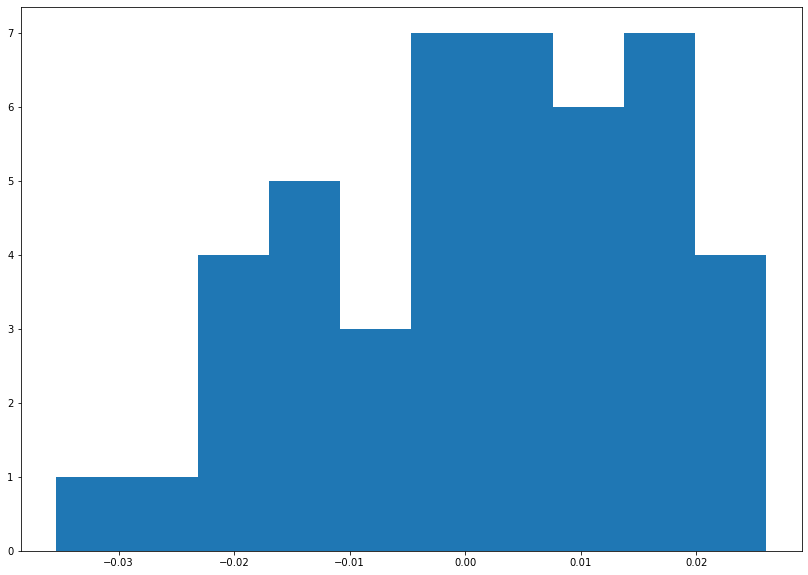

In [226]:
plt.hist(np.array(divs_cont)-1)

In [219]:
ecdf_x1 = ecdf(x1)
ecdf_x2 = ecdf(x2)

TypeError: ecdf() missing 2 required positional arguments: 'tot_min' and 'tot_max'

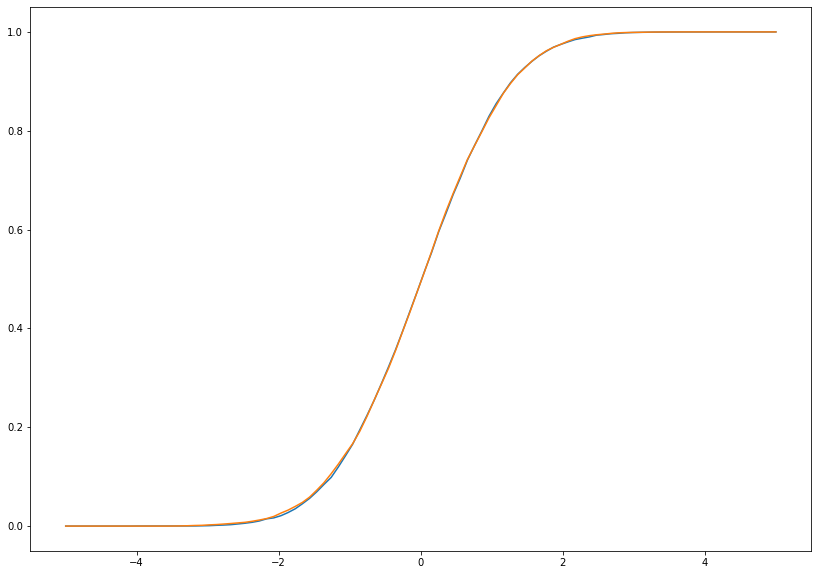

In [187]:
xx = np.linspace(-5,5,num=100)
plt.plot(xx,ecdf_x1(xx))
plt.plot(xx,ecdf_x2(xx))
plt.show()